In [88]:
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

## Define objective function and constraints

In [296]:
# implement a simple non-convex objective function (Banana)
def f(x, grad=False):
    if grad:
        return np.array([
            (x[0] - 2.) - 800. * x[0] * (x[1] - x[0]**2),
            400. * (x[1] - x[0]**2)
        ])
    return (2. - x[0])**2 + 200. * (x[1] - x[0]**2)**2


# inequality constraint for this problem
def penalty(x, grad=False):
    if grad:
        constraint = x[0] - 1
        if constraint > 0:
            return np.array([2. * constraint, 0])
        else:
            return 0
    return np.maximum(0, x[0] - 1.) ** 2

## Visualize data

In [392]:
num_pts = 100

xmin, xmax = -2, 2
ymin, ymax = -1, 4

X, Y = np.meshgrid(
    np.linspace(xmin, xmax, num_pts), 
    np.linspace(ymax, ymin, num_pts)
)
domain = np.stack([X, Y], axis=-1)

cost = f(domain.reshape(-1, 2).T).reshape(num_pts, num_pts)
grad = f(domain.reshape(-1, 2).T, grad=True).reshape(2, num_pts, num_pts)

grad_mag = np.linalg.norm(grad, axis=0)

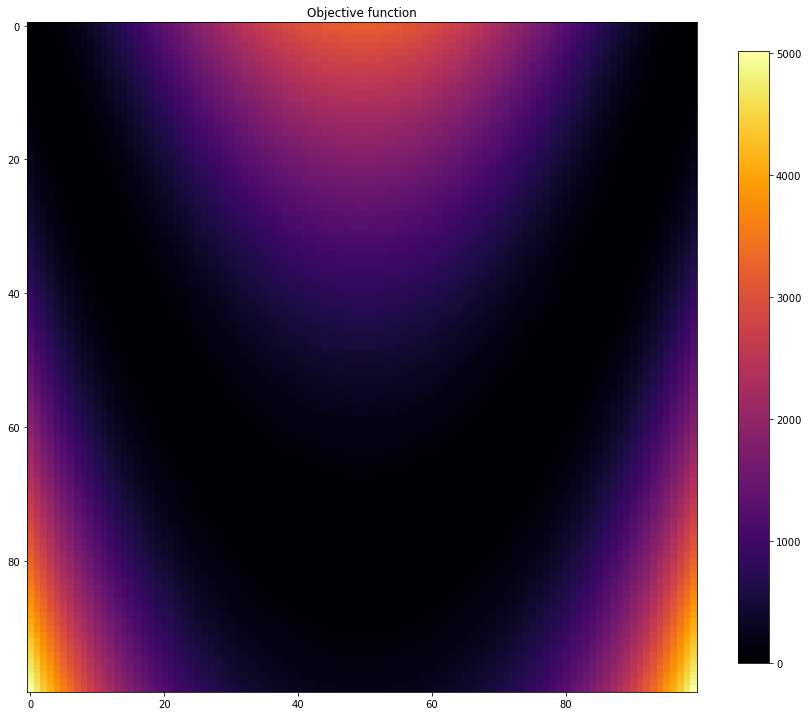

In [393]:
plt.figure(figsize=(15, 15))
plt.title("Objective function")
plt.imshow(cost, cmap='inferno')
plt.colorbar(shrink=0.75);

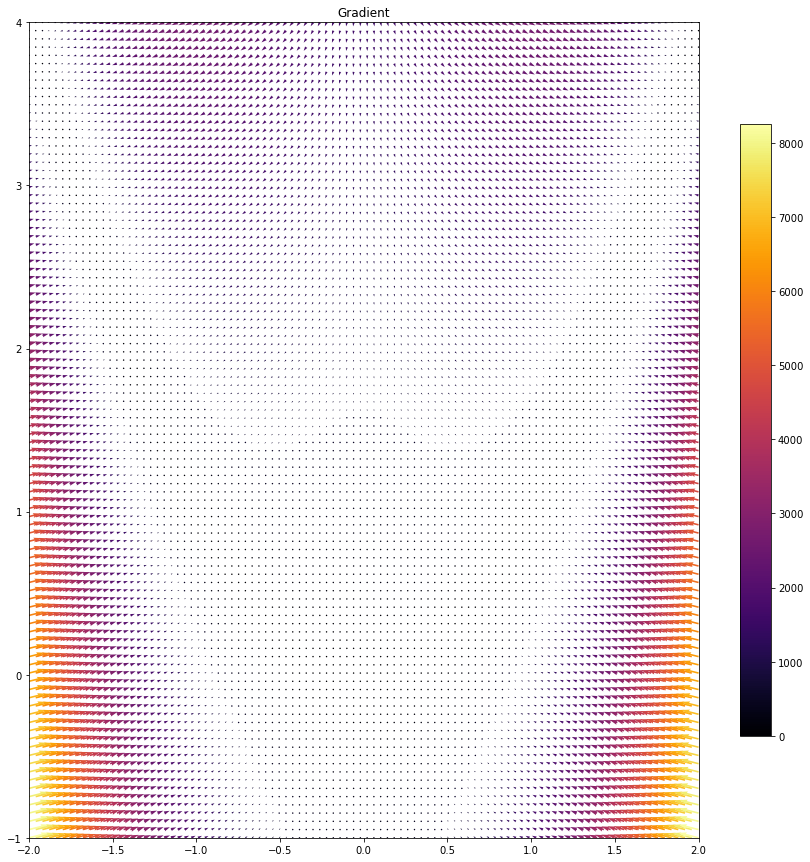

In [395]:
plt.figure(figsize=(15, 15))
plt.title("Gradient")
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
plt.quiver(X, Y, -grad[0], -grad[1], np.linalg.norm(grad, axis=0), cmap='inferno')
plt.colorbar(shrink=0.75);

## Gradient-based optimization
----

### Unconstrained Problem

In [396]:
def line_search(x, objective, grad, a, tau=0.99, c=1e-3):
    while (objective(x) - objective(x - a * grad)) < (a * c * np.sqrt(grad.T @ grad)):
        a *= tau
    return a


def gradient_descent(init, objective, iterations, eps=1e-2, alpha=1e-3):
    x = init
    traj = [init.copy()]
    alphas = [alpha * 1]
    
    for i in tqdm(range(iterations), desc="Running gradient descent"):
        
        grad = objective(x, grad=True)
        
        # stopping condition
        if np.sqrt(grad.T @ grad) <= eps:
            print(f"Halting optimization at iteration {i} for x* = {x}")
            break
            
        alpha = line_search(x, objective, grad, a=alpha)
        x -= alpha * grad
        
        alphas.append(alpha)
        traj.append(x)
        
    return np.array(traj), np.array(alphas)

In [397]:
trajectory, alphas = gradient_descent(
    np.array([1.5, 2.5]),
    f,
    1000000, 
    eps=1e-2,
    alpha=1e-4
)

Running gradient descent:  34%|█████████████████████████▋                                                 | 342326/1000000 [00:05<00:10, 64398.91it/s]


Halting optimization at iteration 342326 for x* = [1.95955329 3.83982487]


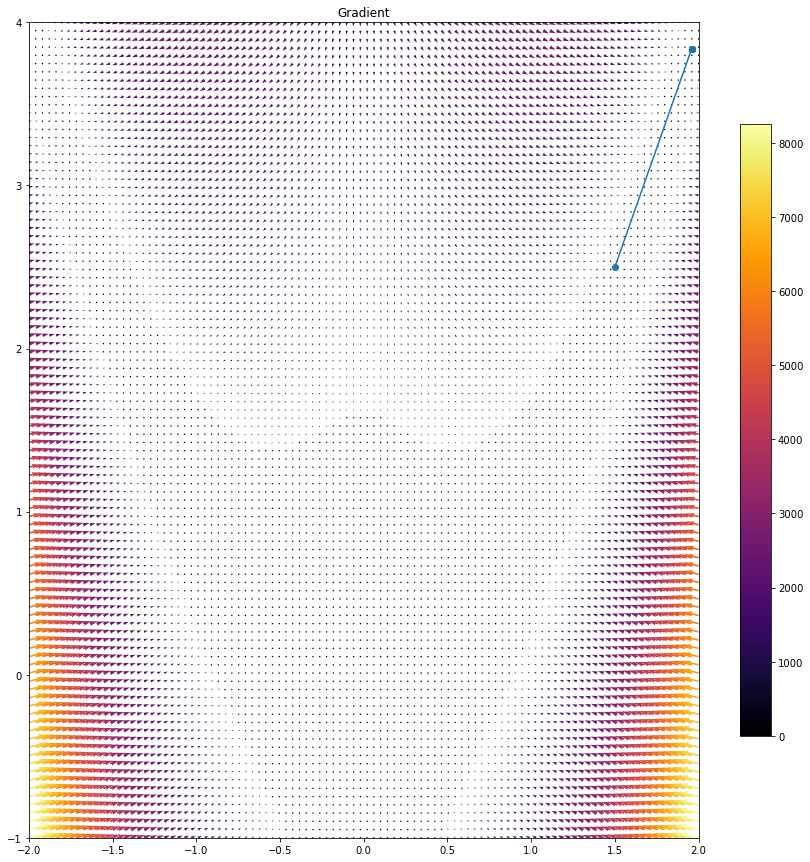

In [411]:
plt.figure(figsize=(15, 15))
plt.title("Gradient")
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
plt.plot(trajectory[:, 0], trajectory[:, 1], '-o')
plt.quiver(X, Y, -grad[0], -grad[1], np.linalg.norm(grad, axis=0), cmap='inferno')
plt.colorbar(shrink=0.75);

### Constrained Problem

In [438]:
def line_search_with_penalty(x, objective, penalty, grad, a, mu, tau=0.99, c=1e-3):
    old = objective(x) + mu * penalty(x)
    new = objective(x - a * grad) + mu * penalty(x - a * grad)
    while (old - new) < (a * c * np.sqrt(grad.T @ grad)):
        a *= tau
        old = objective(x) + mu * penalty(x)
        new = objective(x - a * grad) + mu * penalty(x - a * grad)
    return a


def gradient_descent_with_penalty(init, objective, penalty, iterations, eps=1e-2, alpha=1e-3, mu=1e-4):
    x = init
    traj = [init.copy()]
    alphas = [alpha * 1]
    
    for i in tqdm(range(iterations), desc="Running gradient descent"):
        
        grad = objective(x, grad=True) + mu * penalty(x, grad=True)
        
        # stopping condition
        if np.sqrt(grad.T @ grad) <= eps:
            print(f"Halting optimization at iteration {i} for x* = {x}")
            break
            
        alpha = line_search_with_penalty(x, objective, penalty, grad, a=alpha, mu=mu)
        x -= alpha * grad
        
        mu += 1e-2
        
        alphas.append(alpha)
        traj.append(x)
        
    return np.array(traj), np.array(alphas)

In [439]:
traj_pen, alphas_pen = gradient_descent_with_penalty(
    np.array([0.75, 3.]),
    f,
    penalty,
    1000000, 
    eps=1e-2,
    alpha=1e-3,
    mu=1.0
)

Running gradient descent:   2%|█▍                                                                          | 19035/1000000 [00:00<00:25, 38711.40it/s]


Halting optimization at iteration 19035 for x* = [1.00254802 1.00507939]


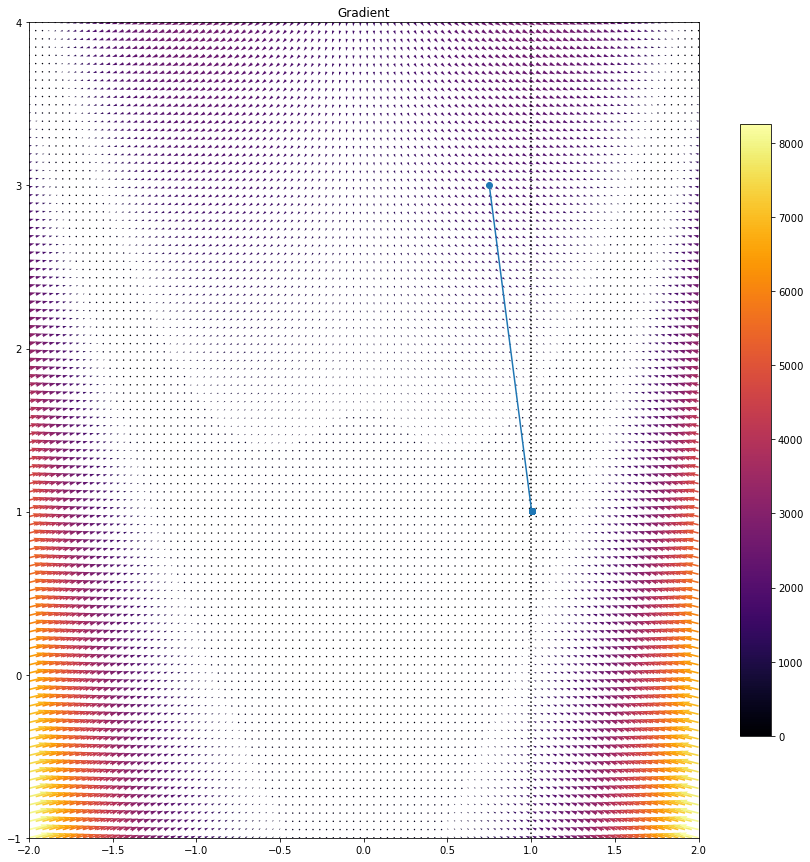

In [440]:
plt.figure(figsize=(15, 15))
plt.title("Gradient")
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
plt.vlines(1., ymin, ymax, linestyles="dotted", colors='k')
plt.plot(traj_pen[:, 0], traj_pen[:, 1], '-o')
plt.quiver(X, Y, -grad[0], -grad[1], np.linalg.norm(grad, axis=0), cmap='inferno')
plt.colorbar(shrink=0.75);